In [28]:
from scipy.optimize import linprog
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from gurobi import *

from dynamic_matching import DynamicMatchingBase
np.set_printoptions(precision=3)

### Define some utility functions

In [2]:
def in_constraint(v):
    if v[1]:
        return True
    else:
        return False

def print_tableau(matches):
    for i in range(matches.shape[2]):
        print("t=",i)
        print(matches[:,:,i])
        
def validate_allocation(allocations):
    agents_matched = allocations.sum(axis=2).sum(axis=0).sum()
    print("{} out of {} agents matched".format(agents_matched, J))
    print("{} agents have self matched".format(allocations[0,:,:].sum()))
    print("Self-matched agents are: ", np.nonzero(allocs[0,:,:].sum(axis=1))[0])

    assert agents_matched <= J, "An agent has been matched more than once"

    for i in range(I):
        for j in range(J):
            for t in range(T):
                maxit = min(T, t+d)
                assert allocations[i,j,t:maxit].sum() <= c[i], "A resource has been over allocated"

def create_tableau(I,J,T):
    valid_matches = np.zeros((I,J,T), np.int)

    #valid allocations based on arival time
    for t in range(T):
        valid_matches[:,max(0,t-d):min(t+1,J),t] = 1

    #make weights uniform across time
    pairing_weights = np.random.random(valid_matches.shape) 
    for t in range(1,pairing_weights.shape[2]):
        pairing_weights[:,:,t] = pairing_weights[:,:,0]
    
    pairing_weights[0,:,:] = 1e-5
    pairing_weights[valid_matches == 0] = -1

    return valid_matches, pairing_weights

def make_alpha_mapping(I,J,T,alphas,valid_matches):
    constraints_d, _ = dual_constraint_matrix(valid_matches,pairing_weights,I,J,T)
    constraints_d = constraints_d[:,:alphas.size]
    alpha_map = np.zeros((*valid_matches.shape,constraints_d.shape[1]))

    cix=0
    for i in range(I):
            for j in range(J):
                for t in range(T):
                    if valid_matches[i][j][t]:
                        alpha_map[i,j,t,:] = constraints_d[cix,:]
                        cix += 1
    return alpha_map
    

To make the dual constraint matrix: 
- Create a constraint map to see which alphas/betas apply at a given location in the primal. Each valid location will correspond to a constraint in the dual, and the variables == 1 will be those in the `cmap[i][j][t]`

In [3]:
def primal_constraint_matrix(valid_matches, I,J,T):

    constraints = np.zeros((T*I+J,valid_matches.size))
    cix = 0
    #constraints limiting to one resource allocation in the time interval
    for i in range(I):
        for t in range(T):
            constraint = np.zeros((I,J,T), np.int)
            valid_mask = constraint.copy()
            endix = min(t+k[i],T)
            valid_mask[i,:,t:endix] = 1 
            constraint[(valid_matches == 1) & (valid_mask == 1)] = 1
            constraints[cix,:] = constraint.reshape((1, constraint.shape[0] * constraint.shape[1] * constraint.shape[2]))
            cix += 1

    #constraints limiting each agent to only match once            
    for j in range(J):
        constraint = np.zeros((I,J,T), np.int)
        valid_mask = constraint.copy()
        valid_mask[:,j,:] = 1

        constraint[(valid_matches == 1) & (valid_mask ==1)] = 1
        constraints[cix+j,:] = constraint.reshape((1, constraint.shape[0] * constraint.shape[1] * constraint.shape[2]))
    
    return constraints


def dual_constraint_matrix(valid_matches,pairing_weights,I,J,T):

    constraint_map = np.zeros((I,J,T,T*I+J), np.int)
    cix = 0

    #constraints limiting to one resource allocation in the time interval
    for i in range(I):
        for t in range(T):
            constraint = np.zeros((I,J,T), np.int)
            valid_mask = constraint.copy()

            endix = min(t+k[i],T)
            valid_mask[i,:,t:endix] = 1 
            constraint[(valid_matches == 1) & (valid_mask == 1)] = 1

            constraint_map[:,:,:,cix] = constraint.copy()
            cix += 1

    #constraints limiting each agent to only match once            
    for j in range(J):
        constraint = np.zeros((I,J,T), np.int)
        valid_mask = constraint.copy()
        valid_mask[:,j,:] = 1
        constraint[(valid_matches == 1) & (valid_mask ==1)] = 1
        constraint_map[:,:,:,cix] = constraint.copy()
        cix += 1

    dual_constraint_matrix = np.zeros((valid_matches.sum(), constraint_map.shape[3]))
    inequalities = np.zeros(valid_matches.sum())
    

    cix = 0
    for i in range(I):
        for j in range(J):
            for t in range(T):
                if valid_matches[i][j][t]:
                    dual_constraint_matrix[cix,:] = constraint_map[i,j,t,:] 
                    inequalities[cix] = pairing_weights[i,j,t]
                    cix += 1
    
    return dual_constraint_matrix, inequalities



In [4]:
def primal_solutions(pairing_weights, I, J, T):
    m = Model("dynamicmatch_primal")
    m.modelSense = GRB.MAXIMIZE
    m.setParam( 'OutputFlag', False )

    weights = pairing_weights.reshape(pairing_weights.shape[0] * pairing_weights.shape[1] * pairing_weights.shape[2])
    constraints = primal_constraint_matrix(valid_matches, I,J,T)


    keys = range(constraints.shape[1])
    variables = m.addVars(keys,
                    vtype=GRB.CONTINUOUS,
                     obj=weights,
                     name="primal",
                     lb=0)

    for cix, constraint in enumerate(constraints):
        equality = c[cix // T] if cix < T * I else 1
        m.addConstr(sum(variables[o]*c for o,c in filter(in_constraint, zip(variables,constraint))) <= equality)

    m.optimize()
    m.write('primal_formulation.lp')
    allocations = np.array([variables[var].X for var in variables]).reshape(pairing_weights.shape)

    return m.objVal, allocations


def dual_solutions(valid_matches, pairing_weights, I, J, T):
    md = Model("dynamicmatch_dual")
    md.modelSense = GRB.MINIMIZE
    md.setParam( 'OutputFlag', False )

    constraints_d, inequalities = dual_constraint_matrix(valid_matches,pairing_weights,I,J,T)
    c_d = np.ones(constraints_d.shape[1])
    
    for ix in range(constraints_d.shape[1]):
        c_d[ix] = c[ix // T] if ix < T * I else 1
    
    keys = range(constraints_d.shape[1])
    variables = md.addVars(keys,
                    vtype=GRB.CONTINUOUS,
                    obj=c_d,
                    name="dual",
                    lb=0)

    for cix, constraint in enumerate(constraints_d):
        con = sum(variables[o]*c for o,c in filter(in_constraint, zip(variables,constraint))) >= inequalities[cix]
        md.addConstr(sum(variables[o]*c for o,c in filter(in_constraint, zip(variables,constraint))) >= inequalities[cix])

    md.optimize()
    duals = np.array([variables[var].X for var in variables])
    betas = duals[duals.size - J:]
    alphas = duals[:duals.size - J]
    
    md.write('dual_formulation.lp')
    return md.objVal, alphas, betas




### Basic online allocation alogrithm implementation
- At each time, for each candidate resource / utility pair, allocate if assignment term less than epsilon
- Track validity of candidate matches based on arrival/departure model, previously matched agents, and resource utilization times


In [35]:
def make_alpha_tableau(valid_matches, alphas, I, T):

    alpha_tableau = np.zeros(valid_matches.shape)
    ii = 0
    it = 0
    for ax, alpha in enumerate(alphas):

        if ii < I:
            use_length = k[ax // T]
            alpha_tableau[ii,:,it:it+use_length] = alpha
            it = it+use_length

            if it >= alpha_tableau.shape[2]:
                it = 0
                ii += 1
                
    return alpha_tableau

In [36]:
def online_matching(I,J,T,k,c,alphas,betas,valid_matches,pairing_weights,epsilon):

    alpha_tableau = make_alpha_tableau(valid_matches, alphas, I, T)
    online_allocations = np.zeros(pairing_weights.shape)
    comps = np.zeros(pairing_weights.shape)
    utility = 0
    candidate_matches = valid_matches.copy()

    for t in range(T):
        for i in range(1,I):
            for j in range(J):
                if candidate_matches[i,j,t]:

                    tmax = min(t+k[i]-1, T)
                    asum = np.sum(alpha_tableau[i,j,t:tmax])

                    comps[i,j,t] = np.abs(pairing_weights[i,j,t] - asum - betas[j])
                    #allocate if less than epsilon
                    if np.abs(pairing_weights[i,j,t] - asum - betas[j]) <= epsilon:
                        online_allocations[i,j,t] = 1
                        utility += pairing_weights[i,j,t]

                        #prevent matches based on constraints
                        candidate_matches[i,:,t:tmax] = 0
                        candidate_matches[:,j,:] = 0
                    
                    #agent hasn't been allocated, self match
                    elif j == t - d:
                        online_allocations[0,j,t] = 1
                        utility += pairing_weights[0,j,t]
                        candidate_matches[:,j,:] = 0                 
    
    return utility, online_allocations


### Define situation variables

In [7]:
J = 6 # number of agents
d = 2 # wait time for each agent

I = 3 # number of resources
# k = np.random.randint(14,19, size=(I)) # utilization time for resource i
# c = np.random.randint(2,3, size=(I)) # number of copies for resource i
k=np.array([1,5,7])
c=np.array([J,1,1])

# c[0] = J
# k[0] = 1

T = J+d # total time for matches to occur

valid_matches, pairing_weights = create_tableau(I,J,T)

# Testing online matching

# Testing different dual scenarios 

### First get a baseline for the alphas

In [8]:
objp, allocs = primal_solutions(pairing_weights, I, J, T)
objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
alpha_viz = make_alpha_viz_representation(valid_matches, alphas, I, T)

print("primal utility:",objp)
print("dual utility:",objd)

validate_allocation(allocs)

alpha_viz = make_alpha_viz_representation(valid_matches, alphas, I, T)
print_tableau(allocs)
print_tableau(alpha_viz)

print(betas)

Academic license - for non-commercial use only
primal utility: 1.8146489606619092
dual utility: 1.8146489606619096
6.0 out of 6 agents matched
3.0 agents have self matched
Self-matched agents are:  [1 2 3]
t= 0
[[0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 1
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 2
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 3
[[0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 4
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 5
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 6
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
t= 7
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 0
[[0.         0.         0.         0.         0.         0.        ]
 [0.38771552 0.38771552 0.38771552 0.38771552 0.38771552 0.38771552]
 [0.         0.         0.         0.         0.         0.        ]]
t= 1
[[0.         0.         

In [10]:
pwt = pairing_weights.copy()

### Test one. Lets make one resource a little bettter overall

In [11]:
pairing_weights[1,:,:] += .58
pairing_weights[valid_matches == 0] = -1


In [12]:
objp, allocs = primal_solutions(pairing_weights, I, J, T)
objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
alpha_viz = make_alpha_viz_representation(valid_matches, alphas, I, T)

print("primal utility:",objp)
print("dual utility:",objd)

validate_allocation(allocs)

print_tableau(allocs)
print_tableau(alpha_viz)

primal utility: 2.974648960661909
dual utility: 2.9746489606619093
6.0 out of 6 agents matched
3.0 agents have self matched
Self-matched agents are:  [1 2 3]
t= 0
[[0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 1
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 2
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 3
[[0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 4
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 5
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 6
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 7
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
t= 0
[[0.         0.         0.         0.         0.         0.        ]
 [0.96771552 0.96771552 0.96771552 0.96771552 0.96771552 0.96771552]
 [0.         0.         0.         0.         0.         0.        ]]
t= 1
[[0.         0.         0.         0.         0.         0.        ]
 [0

### Test two. Lets make an agent a little better overall

In [25]:
pairing_weights = pwt.copy()

pairing_weights[:,1,:] += 100
pairing_weights[valid_matches == 0] = -1


In [30]:
np.max(pairing_weights)

100.28429543866477

In [26]:
objp, allocs = primal_solutions(pairing_weights, I, J, T)
objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
alpha_viz = make_alpha_viz_representation(valid_matches, alphas, I, T)

print("primal utility:",objp)
print("dual utility:",objd)

validate_allocation(allocs)

print_tableau(allocs)
print_tableau(alpha_viz)

primal utility: 101.81464896066193
dual utility: 101.81464896066191
6.0 out of 6 agents matched
3.0 agents have self matched
Self-matched agents are:  [1 2 3]
t= 0
[[0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 1
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 2
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 3
[[0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 4
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 5
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 6
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
t= 7
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
t= 0
[[0.         0.         0.         0.         0.         0.        ]
 [0.38771552 0.38771552 0.38771552 0.38771552 0.38771552 0.38771552]
 [0.         0.         0.         0.         0.         0.        ]]
t= 1
[[0.         0.         0.         0.         0.         0.        ]
 [

# Test performance with suboptimal alphas / betas

In [443]:
def plot_performance_curve(epsilon,use_mag=False):

    noise_multipliers = np.linspace(0,1,50)
    performance = []

    for noise_mag in noise_multipliers:
        alphas_tmp = alphas + np.random.uniform(low=-1.0*noise_mag, high=1.0*noise_mag, size=alphas.shape)
        betas_tmp = betas + np.random.uniform(low=-1.0*noise_mag, high=1.0*noise_mag, size=betas.shape)
        
        if use_mag:
            epsilon = noise_mag
        
        objo, _ = online_matching(I,J,T,alphas_tmp,betas_tmp,valid_matches,pairing_weights, epsilon)

        performance.append(objo)
    return np.array(performance)

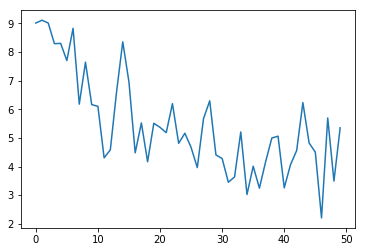

In [477]:
r0 = plot_performance_curve(.1)
plt.plot(r0)

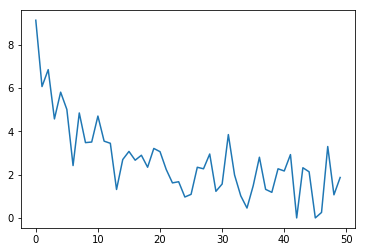

In [478]:
r1 = plot_performance_curve(.01)
plt.plot(r1)

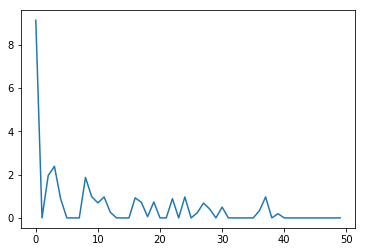

In [479]:
r2 = plot_performance_curve(.001)
plt.plot(r2)

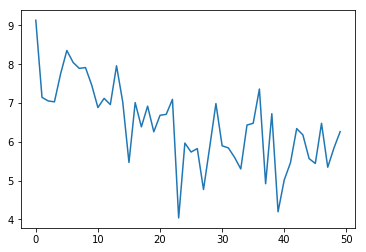

In [482]:
r3 = plot_performance_curve(0,use_mag=True)
plt.plot(r3)